使用设备: cuda
正在加载数据集...


100.0%
c:\Users\28567\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


训练集样本数: 50000
测试集样本数: 10000

模型结构:
InceptionNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (inception3a): InceptionModule(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (branch2): Sequentia

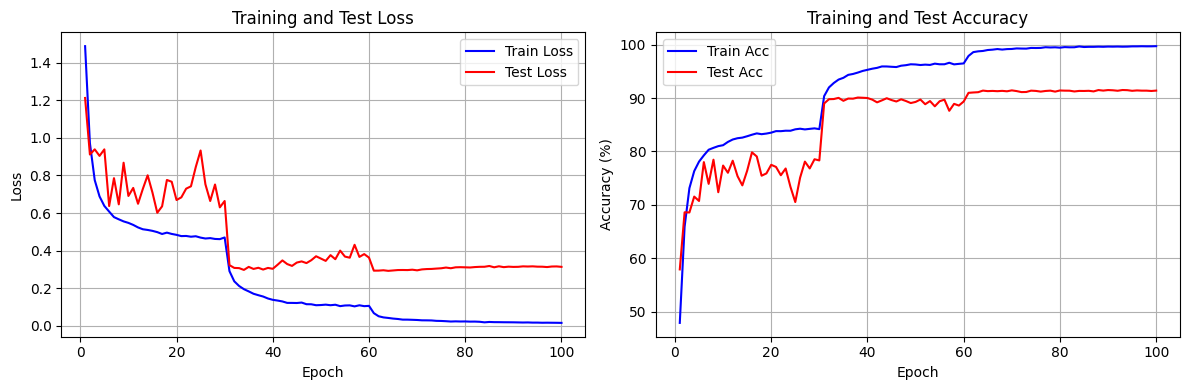

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
import numpy as np


# 基础卷积模块
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


# Inception模块
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()
        
        # 1x1卷积分支
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)
        
        # 1x1卷积后接3x3卷积分支
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )
        
        # 1x1卷积后接5x5卷积分支
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )
        
        # 3x3最大池化后接1x1卷积分支
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


# InceptionNet网络
class InceptionNet(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionNet, self).__init__()
        
        # 初始卷积层
        self.conv1 = BasicConv2d(3, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Inception模块
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        
        # 全局平均池化和全连接层
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        
        x = self.inception4a(x)
        x = self.inception4b(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x


# 训练函数
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f'  Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {running_loss/(batch_idx+1):.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


# 测试函数
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc


# 绘制训练曲线
def plot_curves(train_losses, train_accs, test_losses, test_accs):
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 损失曲线
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss')
    ax1.plot(epochs, test_losses, 'r-', label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True)
    
    # 准确率曲线
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc')
    ax2.plot(epochs, test_accs, 'r-', label='Test Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    print("训练曲线已保存为 training_curves.png")


# 主训练流程
def main():
    # 设置随机种子
    torch.manual_seed(42)
    
    # 设备配置
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # 数据预处理
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # 加载CIFAR-10数据集
    print("正在加载数据集...")
    train_dataset = datasets.CIFAR10(root='./data', train=True, 
                                     download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, 
                                    download=True, transform=transform_test)
    
    train_loader = DataLoader(train_dataset, batch_size=128, 
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=100, 
                            shuffle=False, num_workers=2)
    
    print(f"训练集样本数: {len(train_dataset)}")
    print(f"测试集样本数: {len(test_dataset)}")
    
    # 创建模型
    model = InceptionNet(num_classes=10).to(device)
    print("\n模型结构:")
    print(model)
    
    # 计算模型参数量
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n总参数量: {total_params:,}")
    print(f"可训练参数量: {trainable_params:,}")
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)
    
    # 训练模型
    num_epochs = 100
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    best_acc = 0
    
    print("\n开始训练...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        
        # 训练
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # 测试
        test_loss, test_acc = test(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        # 更新学习率
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f'  训练 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%')
        print(f'  测试 - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%')
        print(f'  学习率: {current_lr}')
        
        # 保存最佳模型
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'  *** 保存最佳模型 (准确率: {best_acc:.2f}%) ***')
    
    total_time = time.time() - start_time
    print(f"\n训练完成! 总耗时: {total_time/60:.2f} 分钟")
    print(f"最佳测试准确率: {best_acc:.2f}%")
    
    # 绘制训练曲线
    plot_curves(train_losses, train_accs, test_losses, test_accs)
    
    # 保存训练历史
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'test_loss': test_losses,
        'test_acc': test_accs
    }
    torch.save(history, 'training_history.pth')
    print("训练历史已保存")


if __name__ == '__main__':
    main()